<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/RL/DZ_1/DZ_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Добашняя работа


**Задача:**

    Найти оптимальную стратегию перемещения таксиста по городу Новинск, используя марковский процесс принятия решений.

**Описание:**

В городе Новинск таксист ездит по решётчатому участку, состоящему из 5x5 ячеек. Он может перемещаться на одну ячейку вверх, вниз, влево или вправо (если не находится на границе). В определённых ячейках находятся пассажиры, а в других ячейках — места назначения.

**Детали:**

- Всего 4 возможных места, где может находиться пассажир `(A, B, C, D)`.
- Есть 4 соответствующих места назначения `(a, b, c, d)`.
- Пассажир может находиться в любом из четырех мест `(A, B, C, D)`
-  и желать доехать до любого из четырёх мест назначения `(a, b, c, d)`.
- Таксист получает:
  - `+10` очков за каждого успешно доставленного пассажира до его пункта назначения
  - и `-1` за каждое движение.
  - Если таксист приезжает на ячейку с пассажиром, он автоматически забирает его.


*По сути необходимо найти наилучшей порядок развозки пассажиров!*
_____________________
**Что нужно сдать:**
- Описание задачи как марковского процесса принятия решений (МППР), включая состояния, действия, награды и переходы между состояниями.
- Код, включающий:
  - Код процесса обучения, реализующего выбранный итеративный метод (например, итерацию по значению или итерацию по стратегии),
  - пример запуска кода обучения (чтобы легко можно было запустить)
  - Код инференса, демонстрирующий работу обученной стратегии на разных вариантах поля.

**Критерии оценивания:**
- Корректность описания МППР (учтены все комбинации состояний,
для каждого состояния определены возможные действия, вероятности переходов корректно установлены, награды за действия и переходы четко определены)

- Код обучения запускается без ошибок.
- Код инференса запускается без ошибок.
- Решение должно набирать больше очков, чем бейзлайн решение на 5 вариантах поля (скрипт для проверки будет выдан).

________________
**Подсказка:**

Рассмотрите каждую возможную комбинацию местоположения такси, местоположения пассажира и пункта назначения пассажира как отдельное состояние. Например, если таксист находится на ячейке (2, 2), пассажир находится в месте B и желает доехать до места c, это одно из возможных состояний.


*Hints*


Пусть есть случайный запрос по транспортировке - Ab Bc Cd Da (т.е. пассажиры (A, B, C, D) хотят добраться до мест(b, c, d, a) соответсвенно. Тогда возможные состояния можно записать так:


```

states = [0 - start_position [0, 0, 0, 0],
         1 - [1, 0, 0, 0],
         2 - [0, 1, 0, 0],
         3 - [0, 0, 0, 1],
         4 - [1, 0, 0, 2],
         5 - [2, 0, 0, 1]
         ...
         ]
```


Действия в задаче - заказы, которые можно взять


```
actions = [1, 2, 3, 4]

```

Вознаграждение - штраф, звычисляемый как расстояние до точки где находится пассажи + расстояние до точки направления:


```
reward =  - dist(previos_place, pessanger) + dist(pessanger, new_place)

```


* Какую стратегию лучше использовать?

# Решение

Стратегия учитывает расстояния до цели `distance_to_target` и пассажира `distance_to_passenger` используется в функции `reward`, она определяет количество очков, которое такси получает за различные действия в среде.

следущие компоненты влияют на вычисление вознаграждения:

- История действий (`Last Actions History`): Функция отслеживает последние действия такси и проверяет, все ли они одинаковые. Если все последние действия одинаковы, то применяется штраф (action_penalty), чтобы избежать зацикливания в действиях.

- Достижение целей (`Achieving Targets`): Если текущее состояние (`state`) такси совпадает с одной из целей (targets), то такси получает вознаграждение за достижение цели.

- Подбор пассажиров (`Picking Up Passengers`): Если текущее состояние такси совпадает с местоположением пассажира (`passengers`), то такси также получает вознаграждение за подбор пассажира.

- Штраф за выход за границы (`Boundary Penalty`): Если такси выходит за границы игрового поля, применяется штраф за это действие.

- Расстояние до пассажира, цели и стен (`Distance to Passenger`, `Target` и  `Wall`): Вознаграждение также зависит от расстояния до ближайшего пассажира, цели и стены. Для каждого шага, который такси делает в направлении пассажира, цели или стены, вычитается небольшая величина (штраф) из вознаграждения.

Эпсилон (`Epsilon`): Это небольшое значение, добавленное к расстоянию, чтобы избежать деления на ноль.

Функция вознаграждения помогает такси принимать оптимальные решения, максимизируя накопленное вознаграждение в процессе выполнения задачи доставки пассажиров к целям.

## Functions

Фунции позволяют следить за игрой, за движением такси и текущими действиями.

Но для тренировки, лучше отображение закомментировать или False. Так как медленние

см. далее

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import time
import random
import copy

# Устанавливаем matplotlib в режим интерактивного отображения
plt.ion()

# Действия: вверх, вниз, влево, вправо
actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]
action_labels = ['↑', '↓', '←', '→']

def generate_locations(num_locations, field_size, avoid_locations=None):
    locations = set()
    while len(locations) < num_locations:
        loc = (np.random.randint(0, field_size[0]), np.random.randint(0, field_size[1]))
        if avoid_locations and loc not in avoid_locations:
            locations.add(loc)
        elif not avoid_locations:
            locations.add(loc)
    return list(locations)

def step(state, action):
    some_state = (state[0] + action[0], state[1] + action[1])
    if some_state[0] < 0 or some_state[0] >= field_size[0] or some_state[1] < 0 or some_state[1] >= field_size[1]:
        return state # Столкновение со стеной
    else:
        return some_state

def in_boundaries(state):
  return state[0] < 0 or state[0]>=7 or state[1] < 0 or state[1]>=7


def distance_to_passenger(car_position, passengers):
    """
    Вычисляет расстояние между текущим положением такси и ближайшим пассажиром.

    Параметры:
        car_position (tuple): Координаты текущего положения такси.
        passengers (list): Список координат пассажиров.

    Возвращает:
        distance (float): Расстояние между такси и ближайшим пассажиром.
    """
    min_distance = float('inf')
    for passenger in passengers:
        dist = abs(car_position[0] - passenger[0]) + abs(car_position[1] - passenger[1])
        if dist < min_distance:
            min_distance = dist
    return min_distance

def distance_to_target(car_position, target):
    """
    Вычисляет расстояние от текущего положения такси до цели.

    Параметры:
        car_position (tuple): Координаты текущего положения такси.
        target (tuple): Координаты цели.

    Возвращает:
        distance (float): Расстояние от такси до цели.
    """
    return abs(car_position[0] - target[0]) + abs(car_position[1] - target[1])




def softmax(x):
    """Вычисление softmax для списка значений."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def draw_stochastic_policy(policy, passengers, car, targets, ax = None,
                           reward = None, completed_passengers =[], field_size=(7, 7),
                           car_position=None, idx_game = ""):
    """
    Отображает текущее состояние среды, включая такси, пассажиров и цели,
    а также текущее игровое вознаграждение.

    Параметры:
        ax (Axes): Объект Axes для построения графика.
        policy (numpy.ndarray): Массив, представляющий текущую стратегию.
        passengers (list): Список координат пассажиров.
        car (tuple): Координаты такси.
        targets (list): Список координат целей.
        completed_passengers (list): Список координат пассажиров, которые
            были доставлены.
        reward (float): Текущее игровое вознаграждение.
        field_size (tuple, optional): Размеры поля. По умолчанию (7, 7).
        car_position (tuple, optional): Координаты текущего положения такси.
            По умолчанию None.
    """
    if not ax:
        # Создание экземпляра графика
        fig, ax = plt.subplots()
    ax.set_xlim(0, field_size[1])
    ax.set_ylim(0, field_size[0])
    plt.grid(True)
    plt.xticks(np.arange(0, field_size[1], 1))
    plt.yticks(np.arange(0, field_size[0], 1))

    # Отображение стрелок для текущей стратегии
    for x in range(field_size[0]):
        for y in range(field_size[1]):
            for action_index, (dy, dx) in enumerate(actions):
                action_prob = policy[x, y][action_index]
                arrow_width = 0.01 + 0.2 * action_prob
                arrow_head_width = 0.2 + 0.4 * action_prob
                arrow_head_length = 0.1 + 0.2 * action_prob
                arrow_properties = dict(facecolor="black", width=arrow_width,
                                        head_width=arrow_head_width,
                                        head_length=arrow_head_length)
                ax.arrow(y + 0.5, x + 0.5, dx * 0.3, dy * 0.3, **arrow_properties)

    # Отображение пассажиров
    td = 0.5
    markersize = 25
    for p in passengers:
        if p not in completed_passengers:
            ax.plot(p[1]+td, p[0]+td, 'go', markersize=markersize)
            ax.text(p[1]+td, p[0]+td, 'P', ha='center', va='center', color='white')

    # Отображение такси
    ax.scatter(car[1]+td, car[0]+td, color='orange', s=400)
    ax.text(car[1]+td, car[0]+td, 'S', ha='center', va='center', color='white')

    # Отображение целей
    for t in targets:
        ax.plot(t[1]+td, t[0]+td, 'bo', markersize=markersize)
        ax.text(t[1]+td, t[0]+td, 'T', ha='center', va='center', color='white')

    # Отображение уже доставленных пассажиров
    for cp in completed_passengers:
        ax.plot(cp[1]+td, cp[0]+td, 'go', markersize=markersize)
        ax.text(cp[1]+td, cp[0]+td, 'TP', ha='center', va='center', color='green')

    # Отображение положения такси
    if car_position:
        # Если такси находится в определенном положении, отобразить его на графике
        # с использованием красной маркерной точки
        ax.scatter(car_position[1]+td, car_position[0]+td, color='red', s=400)

        # Добавить текст "C" в центр маркерной точки такси, чтобы обозначить его
        ax.text(car_position[1]+td, car_position[0]+td, 'C', ha='center', va='center', color='white')

    if reward:
        # Отображение текущего вознаграждения
        ax.text(0.5, -0.1, f'Current Game {idx_game} reward: {reward:.2f}', horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes, fontsize=12, fontweight='bold', color='blue')

    # Инвертирование оси Y и отключение осей
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()


def stochastic_policy_improvement(V, actions, targets, passengers, car_position, epsilon, gamma=0.99):
    policy = np.zeros((field_size[0], field_size[1]), dtype=object)
    for x in range(field_size[0]):
        for y in range(field_size[1]):
            if (x, y) in targets or (x, y) in passengers or in_boundaries((x, y)):
                # На границах, в пассажирах и целях оставляем вероятности действий равными 0
                policy[x, y] = [0] * len(actions)
            else:
                if np.random.random() < epsilon:
                    # Случайное действие с вероятностью epsilon
                    action_index = np.random.choice(len(actions)) # Изменено на случайный выбор индекса действия
                else:
                    action_values = np.array([
                        reward(step((x, y), a), targets, passengers, (x, y), a) +
                        gamma * V[step((x, y), a)]
                        for a in actions
                    ])
                    action_index = np.argmax(action_values)
                # Равномерное распределение вероятностей для случайного выбора
                action_probabilities = np.ones(len(actions)) / len(actions)
                action_probabilities[action_index] = 1.0
                policy[x, y] = action_probabilities
    return policy



# Глобальные переменные для отслеживания последних действий и времени
last_actions = []
last_actions_timestamp = 0
action_penalty = -1  # Штраф за повторение одних и тех же действий

def update_passengers_and_targets(passengers, targets, completed_passenger, completed_target):
    """
    Обновляет списки пассажиров и целей после их достижения.

    Параметры:
        passengers (list): Список координат пассажиров.
        targets (list): Список координат целей.
        completed_passenger (tuple): Координаты достигнутого пассажира.
        completed_target (tuple): Координаты достигнутой цели.

    Возвращает:
        passengers (list): Обновленный список координат пассажиров.
        targets (list): Обновленный список координат целей.
    """
    if completed_passenger in passengers:
        passengers.remove(completed_passenger)
    if completed_target in targets:
        targets.remove(completed_target)
    return passengers, targets

def reward(state, targets, passengers, car_position, action, reset_time=10, max_actions_history=10):
    global last_actions, last_actions_timestamp

    # Проверка, прошло ли достаточно времени для сброса истории действий
    current_time = time.time()
    if current_time - last_actions_timestamp > reset_time:
        last_actions = []
        last_actions_timestamp = current_time

    # Добавление текущего действия в историю
    last_actions.append(action)

    if len(last_actions) > max_actions_history:
        # Удаление старых действий, если превышен предел истории
        last_actions = last_actions[1:]

    # Проверка, все ли действия в последней истории одинаковые
    if len(set(last_actions)) == 1:
        # Если все действия одинаковые, применяем штраф
        return action_penalty
    else:
        # В противном случае, применяем обычное вознаграждение
        if not targets:
            # Обработка случая, когда список targets пуст
            return -1000  # Некоторое базовое отрицательное значение
        elif state in targets:
            return 10  # Вознаграждение за достижение цели
        elif state in passengers:
            return 10  # Вознаграждение за взятие пассажира
        elif state in passengers and state in targets:
            return 50  # Вознаграждение за взятие пассажира
        elif in_boundaries(state):
            return -1000  # Штраф за выход за границы
        else:
            # Используйте расстояния для модификации вознаграждения
            dist_to_passenger = distance_to_passenger(car_position, passengers)
            dist_to_target = distance_to_target(car_position, targets[0])
            # Расстояние до ближайшей стены
            dist_to_wall = min(state[0], field_size[0] - state[0], state[1], field_size[1] - state[1])

            # Добавим эпсилон, чтобы избежать деления на ноль
            epsilon = 1e-6
            # Штраф за каждый шаг, умноженный на расстояние
            return -0.01 * dist_to_passenger - 0.01 * dist_to_target - 0.01 * dist_to_wall + epsilon



def stochastic_policy_iteration(field_size, passengers=[],  targets=[], num_games=10, show_process=False, decay_rate=0.01):
    """
    Обучение с использованием итерации стохастической политики.

    Args:
        passengers (list): Список местоположений пассажиров.
        field_size (tuple): Размер поля (высота, ширина).
        targets (list, optional): Список местоположений целей. Defaults to [].
        num_games (int, optional): Количество игр для обучения. Defaults to 10.
        show_process (bool, optional): Флаг для отображения процесса обучения. Defaults to False.
        decay_rate (float, optional): Скорость уменьшения epsilon. Defaults to 0.01.

    Returns:
        tuple: Кортеж содержащий обученную политику, оценочные значения состояний и список общих вознаграждений.
    """
    total_rewards = []
    policy = np.full((field_size[0], field_size[1]), None, dtype=object)
    V = np.zeros((field_size[0], field_size[1]))
    gamma = 0.99
    threshold = 0.005
    epsilon = 0.9  # Начальное значение epsilon
    epohs = 50

    for game in range(num_games):
        total_reward = 0
        is_policy_stable = False
        completed_passengers = []
        completed_targets = []
        if not len(passengers):
            passengers = generate_locations(num_passengers, field_size)
        # Генерируем местоположения целей, если они не указаны
        if not len(targets):
            avoid_locations = set(passengers)
            targets = generate_locations(num_targets, field_size, avoid_locations)

        # Установка начального значения epsilon для текущей игры
        if game < int(num_games * 0.2):
            epsilon = 1.0
        elif game == int(num_games * 0.2):
            epsilon = 0.9
        else:
            epsilon *= 0.99

        # Случайное начальное состояние такси
        game_passengers = copy.deepcopy(passengers)
        avoid_locations = set(game_passengers).union(set(targets))
        car_state = generate_locations(1, field_size, avoid_locations)[0]
        car_start = car_state

        # Итерации по эпохам
        for i in range(epohs):
            while True:
                delta = 0
                for x in range(field_size[0]):
                    for y in range(field_size[1]):
                        v = V[x, y]
                        action_probabilities = policy[x, y] if policy[x, y] is not None else np.ones(len(actions)) / len(actions)
                        V[x, y] = sum([p * (reward(step((x, y), a), targets, game_passengers, (x, y), a) + gamma * V[step((x, y), a)]) for a, p in zip(actions, action_probabilities)])
                        delta = max(delta, abs(v - V[x, y]))
                if delta < threshold:
                    break

            new_policy = stochastic_policy_improvement(V, targets=targets, passengers=game_passengers, actions=actions, car_position=car_state, gamma=gamma, epsilon=epsilon)

            # Проверка на стабильность политики
            is_policy_stable = all(np.array_equal(policy[x, y], new_policy[x, y]) for x in range(field_size[0]) for y in range(field_size[1]))
            policy = new_policy

            state = car_state  # Используем текущее состояние такси как начальное
            while state not in targets:
                action_probabilities = policy[state[0], state[1]]
                if np.sum(action_probabilities) != 0:
                    action_probabilities /= np.sum(action_probabilities)
                else:
                    action_probabilities = np.ones_like(action_probabilities) / len(action_probabilities)

                action_probabilities /= np.sum(action_probabilities)

                action_index = np.random.choice(len(actions), p=action_probabilities)
                action = actions[action_index]

                next_state = step(state, action)
                total_reward += reward(next_state, targets, game_passengers, state, action)

                car_state = next_state

                for passenger in game_passengers:
                    if passenger == next_state:
                        game_passengers.remove(passenger)
                        completed_passengers.append(passenger)

                # Обновление состояния такси и списков пассажиров и целей
                car_state = next_state

                if show_process:
                    draw_stochastic_policy(policy=policy, passengers=game_passengers,
                                           completed_passengers=completed_passengers,
                                           car=car_start, targets=targets,
                                           field_size=field_size, car_position=car_state,
                                           reward=total_reward, idx_game=game)
                else:
                    print(f"Game_{game}_reward_{total_reward:.3f}_eps_{epsilon:.3e}")

                time.sleep(0.1)
                clear_output(True)

                state = next_state

        total_rewards.append(total_reward)

    clear_output(True)

    draw_stochastic_policy(policy=policy, passengers=game_passengers,
                           completed_passengers=completed_passengers,
                           car=car_start, targets=targets, field_size=field_size,
                           car_position=car_state, reward=total_reward)

    return policy, V, total_rewards



def inference(policy, field_size, passengers, car, targets):

    """
    Проведение инференса на основе обученной политики.

    Args:
        policy (numpy.ndarray): Обученная политика.
        field_size (tuple): Размер поля (высота, ширина).
        passengers (list): Список местоположений пассажиров.
        car (tuple): Местоположение такси.
        targets (list): Список местоположений целей.

    Returns:
        None
    """

    completed_passengers = []  # Создаем список для сбора доставленных пассажиров
    total_reward = 0  # Инициализируем общее вознаграждение

    # Показываем начальное состояние игры
    draw_stochastic_policy(policy=policy, passengers=passengers,
                           car=car, targets=targets, field_size=field_size, reward=total_reward)
    time.sleep(0.1)  # Задержка для наглядности
    clear_output(True)

    # Продвигаемся по игре в соответствии с обученной стратегией
    car_state = car
    while passengers:
        action_probabilities = policy[car_state[0], car_state[1]]
        if np.sum(action_probabilities) != 0:
            action_probabilities /= np.sum(action_probabilities)
        else:
            # Обработка случая, когда сумма вероятностей равна нулю
            # Например, установка равномерного распределения вероятностей
            action_probabilities = np.ones_like(action_probabilities) / len(action_probabilities)

        action_index = np.random.choice(len(actions), p=action_probabilities)
        action = actions[action_index]
        next_state = step(car_state, action)

        # Обновляем положение такси
        car_state = next_state

        time.sleep(0.1)  # Задержка для наглядности
        clear_output(True)
        # Выводим график в конце  игры
        total_reward += reward(next_state, targets, passengers, car_state, action)  # Обновляем общее вознаграждение
        draw_stochastic_policy(policy=policy, passengers=passengers,
                                completed_passengers=completed_passengers,
                                car=car, targets=targets, field_size=field_size,
                                car_position=car_state, reward=total_reward)

        # Обновляем состояние пассажиров
        for passenger in passengers:
            if passenger == next_state:
                passengers.remove(passenger)
                # Добавляем доставленного пассажира в список
                completed_passengers.append(passenger)

    print("All passengers have been delivered!")

## Train

- можно указать конкретные passengers и targets, или будут создаваться случайные

- можно смотреть игры, если раскоментировать show_process = True, или будет просто выводится какая игра и текущий реворд в игре и  текущий эпсилон и номер игры

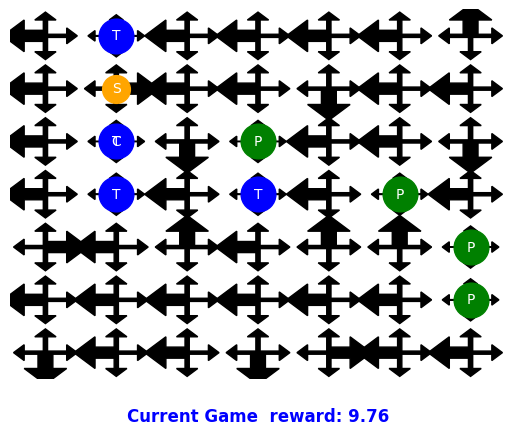

Game 1: Total Reward = 10
Game 2: Total Reward = 19.440005999999997
Game 3: Total Reward = 18.410019
Game 4: Total Reward = 9.440007
Game 5: Total Reward = 7.310033000000001
Game 6: Total Reward = 11.790117999999993
Game 7: Total Reward = -2.219876000000019
Game 8: Total Reward = 9.680004
Game 9: Total Reward = -inf
Game 10: Total Reward = 3.1700569999999955
Game 11: Total Reward = -inf
Game 12: Total Reward = 14.450138999999968
Game 13: Total Reward = 9.750004
Game 14: Total Reward = 29.25009400000002
Game 15: Total Reward = 9.880002
Game 16: Total Reward = 4.530262999999978
Game 17: Total Reward = 24.990054000000008
Game 18: Total Reward = 22.050123000000006
Game 19: Total Reward = 7.52003
Game 20: Total Reward = 48.860011
Game 21: Total Reward = 6.640036
Game 22: Total Reward = 8.100010000000001
Game 23: Total Reward = 38.390017
Game 24: Total Reward = 10
Game 25: Total Reward = 32.870064
Game 26: Total Reward = 17.920021999999996
Game 27: Total Reward = -13.449793999999965
Game 28:

In [130]:
# Параметры среды
field_size = (7, 7)
num_passengers = 4  # Количество пассажиров
num_targets = 4  # Количество пунктов назначения
#passengers = [(1, 1), (2, 2), (4, 5), (5, 2)]  # Местоположения пассажиров
#targets = [(1, 5), (3, 3), (5, 6), (6, 1)]  # Местоположения пунктов назначения

# Количество игр для выполнения
num_games = 100

policy, V, total_rewards = stochastic_policy_iteration(
                                                       #passengers,
                                                       #targets,
                                                       field_size = field_size,
                                                       num_games = num_games,
                                                       #show_process = True
                                                       )

# Вывод результатов игр и среднего вознаграждения
for game in range(num_games):
    print(f"Game {game + 1}: Total Reward = {total_rewards[game]}")

average_reward = np.mean(total_rewards)
print(f"Average Reward over {num_games} games: {average_reward}")






# Inference

показывается игра и текущий реворд

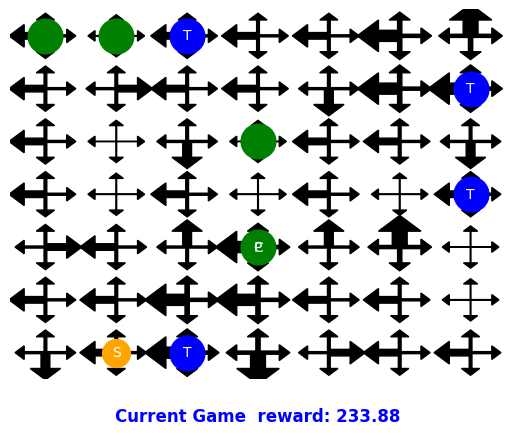

All passengers have been delivered!


In [131]:
num_passengers = 4  # Количество пассажиров
num_targets = 4  # Количество пунктов назначения

passengers = generate_locations(num_passengers, field_size)
avoid_locations = set(passengers)
targets = generate_locations(num_targets, field_size, avoid_locations)
# Генерация начальных местоположений такси без перекрытия с местоположениями пассажиров
avoid_locations = set(passengers + targets)
car = generate_locations(1, field_size, avoid_locations)[0]

# Пример вызова инференса с обученной стратегией
inference(policy, field_size, passengers, car, targets)